## Data Cleaning and Model Building

Firstly, I imported all the libraries I need:

In [1]:
import numpy as np
import re
from io import StringIO
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import requests
import matplotlib.pyplot as plt
import pandas as pd


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\askin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\askin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

I wrote a function the read the novels from URL.

In [2]:
def novel_reader(url):
    response = requests.get(url)

    content = response.text

    return content

And I called the function for both Austen's and Bronte's novels.

In [4]:
austen_url = "https://www.gutenberg.org/cache/epub/1342/pg1342.txt"
austen_content = novel_reader(austen_url)

bronte_url = "https://www.gutenberg.org/cache/epub/1260/pg1260.txt"
bronte_content = novel_reader(bronte_url)

I wrote the clean_novel function with re library to clean the content:

- The first and second lines delete their visual depictions in the content. I don't know why I had to write two lines at the same time, but neither of them worked alone but together they completed the task.
- The third line deletes \n and \r from the content.
- The fourth line deletes spaces where there is more than one space in the content.
- Fifth line deletes the "CHAPTER" expressions from the content.
- The last line converts all content to lowercase.
- Finally, function returns the cleaned text.

In [5]:
def clean_novel(text):

    clean_text = re.sub(r'\[Illustration:[^\]]*\]', '', text)

    clean_text = re.sub(r'\[Illustration\]', '', clean_text)

    clean_text = re.sub(r'[\n\r]', ' ', clean_text)

    clean_text = re.sub(r'\s+', ' ', clean_text)

    clean_text = re.sub(r'CHAPTER \w+', '', clean_text)

    clean_text = clean_text.lower()

    return clean_text

And I called the function with both Austen's and Bronte's novels.

In [6]:
clean_austen_text = clean_novel(austen_content)
clean_bronte_text = clean_novel(bronte_content)

I wrote a function to tokenize text into sentences.

In [7]:
def tokenizer(text):
    tokened_text = nltk.sent_tokenize(text)

    return tokened_text

In [8]:
austen_sent_tokens = tokenizer(clean_austen_text)
bronte_sent_tokens = tokenizer(clean_bronte_text)

In some sentences in the texts, parts that belong to the novel and parts that do not belong to the novel are tokenized together. I cleared them manually for cleaner data.

In [9]:
change_austen = austen_sent_tokens.index("472 the end 476 it is a truth universally acknowledged, that a single man in possession of a good fortune must be in want of a wife.")
austen_sent_tokens[change_austen] = "it is a truth universally acknowledged, that a single man in possession of a good fortune must be in want of a wife."

change_bronte = bronte_sent_tokens.index("daily he announces more distinctly,—‘surely i come quickly!’ and hourly i more eagerly respond,—‘amen; even so come, lord jesus!’” *** end of the project gutenberg ebook jane eyre: an autobiography *** updated editions will replace the previous one—the old editions will be renamed.")
bronte_sent_tokens[change_bronte] = "daily announces distinctly,—‘surely come quickly!’ hourly eagerly respond,—‘amen; even come, lord jesus!’”"

change_bronte_2 = bronte_sent_tokens.index("_april_ 13_th_, 1848.  there was no possibility of taking a walk that day.")
bronte_sent_tokens[change_bronte_2] = "there was no possibility of taking a walk that day."

Then, I determined the parts in the text where the novel begins and ends.

In [10]:
start_austen = austen_sent_tokens.index("it is a truth universally acknowledged, that a single man in possession of a good fortune must be in want of a wife.")
end_austen = austen_sent_tokens.index("darcy, as well as elizabeth, really loved them; and they were both ever sensible of the warmest gratitude towards the persons who, by bringing her into derbyshire, had been the means of uniting them.")

start_bronte = bronte_sent_tokens.index("there was no possibility of taking a walk that day.")
end_bronte = bronte_sent_tokens.index("daily announces distinctly,—‘surely come quickly!’ hourly eagerly respond,—‘amen; even come, lord jesus!’”")

And used the begining and end parts in this function to get the pure novel.

In [11]:
def get_pure_novel(text, start, end):
    pure_text = text[start : end +1]

    return pure_text

In [12]:
pure_austen_text = get_pure_novel(austen_sent_tokens, start_austen, end_austen)
pure_bronte_text = get_pure_novel(bronte_sent_tokens, start_bronte, end_bronte)

In the code block below, made the list of labels.


In [13]:
austen_labels = [0] * len(pure_austen_text)
bronte_labels = [1] * len(pure_bronte_text)

I merged the Austen's and Bronte's novels in merged_list and also I merged the labels in merged_labels list.

In [14]:
merged_list = []
for sentence in pure_austen_text:
    merged_list.append(sentence)

for sentence in pure_bronte_text:
    merged_list.append(sentence)

merged_labels = austen_labels + bronte_labels

I checked the length of both merged_list and merged_labels to see if they are at the same length. If they weren't, I couldn't vectorize them.

In [15]:
len(merged_list)

11452

In [16]:
len(merged_labels)

11452

I used the zip function to merge merged_label and merged_list without losing the index order.

In [17]:
merged_data = list(zip(merged_list, merged_labels))

- I vectorized and deleted stop words from merged_data.
- I converted vectorized_data into array.
- I splitted data into test and train.
- I defined the regression model.
- Then I finally made the prediction.

In [18]:
vectorizer = TfidfVectorizer(stop_words='english')
vectorized_data = vectorizer.fit_transform([item[0] for item in merged_data])

vectorized_data = vectorized_data.toarray()

text_train, text_test, label_train, label_test = train_test_split(vectorized_data, merged_labels, test_size=0.25, random_state=37)

model = LogisticRegression(random_state=37)
model.fit(text_train, label_train)

label_prediction = model.predict(text_test)

In [19]:
conf_matrix = confusion_matrix(label_test, label_prediction)
class_report = classification_report(label_test, label_prediction)

In [20]:
conf_matrix = pd.DataFrame(conf_matrix)
conf_matrix

,0,1
0,836,355
1,62,1610


In [21]:
print(class_report)

              precision    recall  f1-score   support

           0       0.93      0.70      0.80      1191
           1       0.82      0.96      0.89      1672

    accuracy                           0.85      2863
   macro avg       0.88      0.83      0.84      2863
weighted avg       0.87      0.85      0.85      2863



## Analysis of the Model

Precision indicates how many of the samples predicted as a class actually belong to that class. That is, Austen, 93% of the samples predicted by the model are actually Austen, and for Bronte, 82% of the samples predicted by the model are actually Bronte.

In [25]:
def plot_pie_graph(labels, sizes, colors, title="Pie Chart"):
    plt.figure(figsize = (4, 4))
    plt.pie(sizes, labels = labels, colors = colors, autopct = '%1.1f%%', startangle = 50)
    plt.title(title)
    plt.axis('equal')
    plt.show()

As can be seen, 93% of the sentences predicted to be Austen actually belong to Austen.

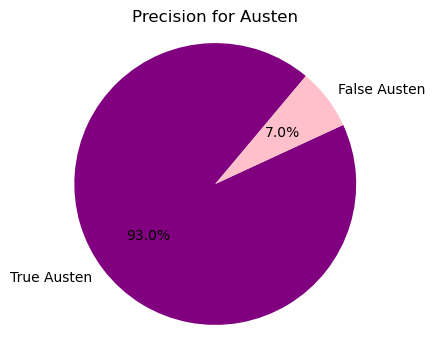

In [26]:
labels = ['True Austen', 'False Austen']
sizes = [0.93, 0.07]
colors = ['purple', 'pink']

plot_pie_graph(labels, sizes, colors, title = "Precision for Austen")

As can be seen, 82% of the sentences predicted to be Bronte actually belong to Bronte. My guess is, the reason why the model was less successful in Bronte may be due to overfitting or underfitting due to the excess of stopwords. Or Austen's choice of more specific words in her writings may have helped her sentences be recognized.

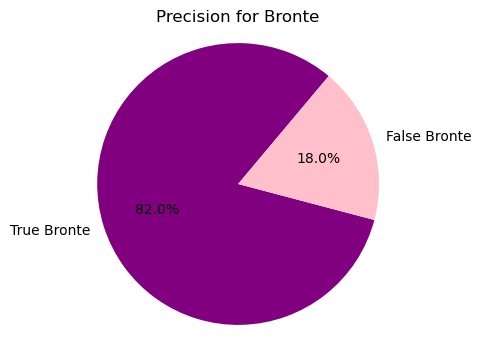

In [29]:
labels = ['True Bronte', 'False Bronte']
sizes = [0.82, 0.18]
colors = ['purple', 'pink']

plot_pie_graph(labels, sizes, colors, title = "Precision for Bronte")

Recall indicates how much of the samples are correctly predicted to actually belong to that class. And we see that Austen's sentences are correctly predicted by 70% and 96% of Bronte's sentences are correctyl predicted.

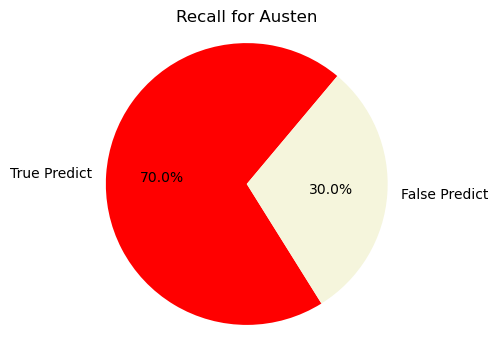

In [28]:
labels = ['True Predict', 'False Predict']
sizes = [0.70, 0.30]
colors = ['red', 'beige']

plot_pie_graph(labels, sizes, colors, title = "Recall for Austen")

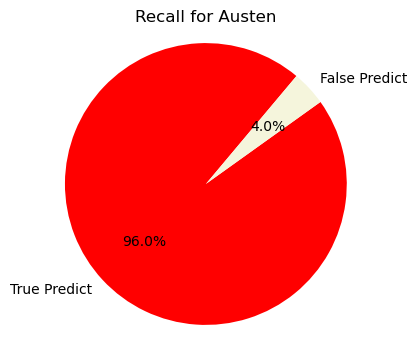

In [30]:
labels = ['True Predict', 'False Predict']
sizes = [0.96, 0.04]
colors = ['red', 'beige']

plot_pie_graph(labels, sizes, colors, title = "Recall for Austen")

F1-Score measures the model's ability to handle both false positives and false negatives in a balanced manner. Since F1-Score values are close to 1, we can say that our model is partially more successful.

In [31]:
def plot_bar_graph(categories, values, xlabel, ylabel, color, title):
    plt.figure(figsize = (5, 5))
    plt.bar(categories, values, color = color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

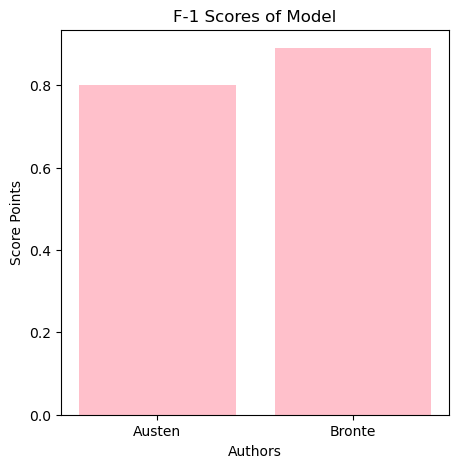

In [32]:
authors = ['Austen', 'Bronte']
values = [0.80, 0.89]

plot_bar_graph(authors, values, xlabel ='Authors', ylabel ='Score Points', color = 'pink', title ="F-1 Scores of Model")

And "Support" is the number of data for each Author:

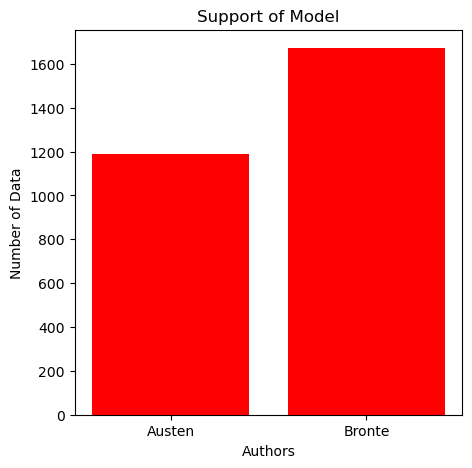

In [33]:
authors = ['Austen', 'Bronte']
values = [1191, 1672]

plot_bar_graph(authors, values, xlabel ='Authors', ylabel ='Number of Data', color = 'red', title ="Support of Model")